In [1]:
!pip install pulp
!pip install yfinance

In [2]:
!pip install cvxpy
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pulp
import scipy.linalg as la
import yfinance as yf

In [3]:
!pip install PyPortfolioOpt

In [4]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import sample_cov
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt import plotting

In [31]:
from datetime import datetime, timedelta, date

## how we load data from yahoo finance

#### Stock data

In [32]:
end_date = datetime.today()
start_date = end_date - timedelta(days = 1*365)

assets = ["EA", "MSFT", "NFLX", "GOOGL", "VRNA", "NICE", "AVDL"]

close = pd.DataFrame()
for s in assets:
    data = yf.download(s, start=start_date, end=end_date)
    close[s] = data['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


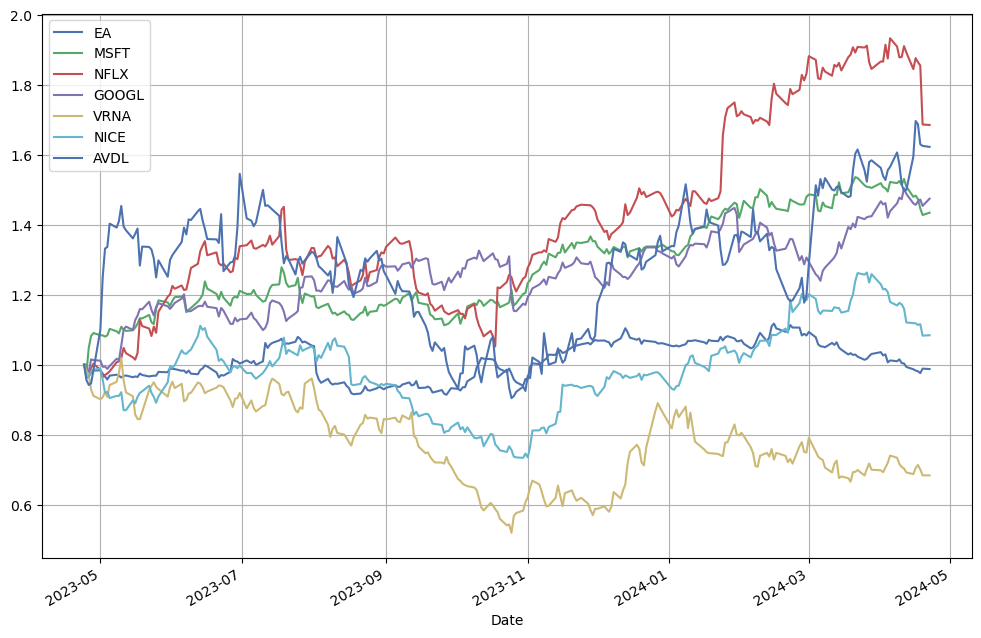

In [33]:
returns=close/close.iloc[0]
returns=returns.dropna()
returns.plot(kind='line',figsize=(12,8),grid=True)
plt.legend(loc='best')

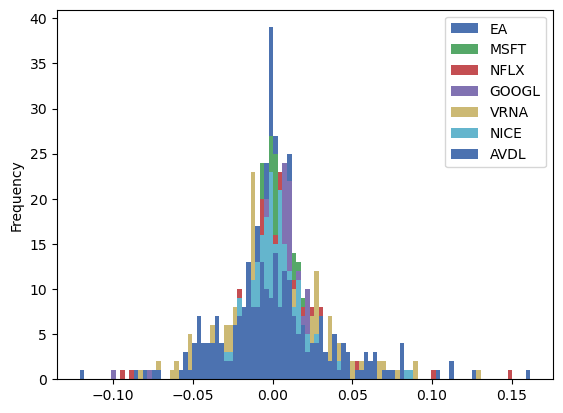

In [34]:
# plotting log return
log_ret=np.log(close/close.shift(1))
log_ret = log_ret.dropna()
log_ret.plot.hist(bins=100)
plt.legend(loc='best')

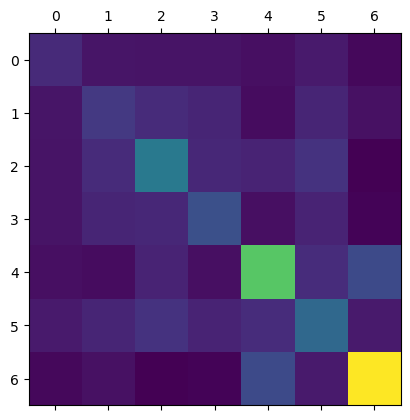

In [35]:
#The sum of the average logarithmic returns of 252 days
mean_ret=log_ret.mean()*252
#252 days of assets constitute a bias matrix
total_covar=log_ret.cov()*252
plt.matshow(total_covar)

In [36]:
R = log_ret.to_numpy()
r = mean_ret.to_numpy()
S = np.cov(R.T)

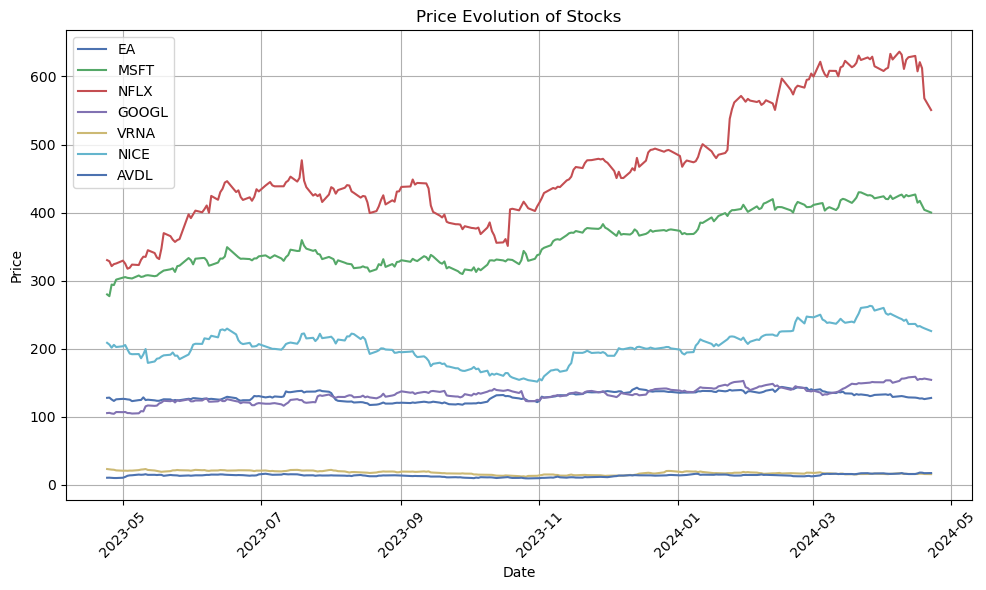

In [37]:
# Create a single plot for all stocks
plt.figure(figsize=(10, 6))

# Plot price evolution of each stock
for stock in assets:
    data = yf.Ticker(stock)
    df = data.history(period="1y")
    plt.plot(df.index, df["Open"], label=stock)

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Price Evolution of Stocks")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# We consider risk as MAD first, all these models are model 1x




# model 1A
when we minimize MAD under a specified expected return $r_0$
$$
\begin{gathered}
\operatorname{maximize} -\frac{1}{T} \sum_{t=1}^T\left|\sum_j x_j\left(R_j(t)-r_j\right)\right| \\
\text { subject to } \sum_j x_j=1 \\
  \sum_j x_j r_j = r_0 \\
x_j \geq 0 \quad j=1,2, \ldots, n, \\
r_j=\frac{1}{T} \sum_{t=1}^T R_j(t)
\end{gathered}
$$

The LP version is
$$
\begin{gathered}
& \operatorname{maximize} -\frac{1}{T} \sum_{t=1}^T y_t \\
& \text { subject to }-y_t \leq \sum_j x_j\left(R_j(t)-r_j\right) \leq y_t \quad t=1,2, \ldots, T \text {, } \\
& \sum_j x_j=1 \\
&  \sum_j x_j r_j = r_0 \\
& x_j \geq 0 \quad j=1,2, \ldots, n, \\
& r_j=\frac{1}{T} \sum_{t=1}^T R_j(t)
\end{gathered}
$$





In [40]:
from pulp import *

# Define the data
n = len(assets)  # Number of assets
T = len(R[:, 0])  # Number of time periods
r0 = 0.2
print(n, T, r0)


# Create a LP problem
prob = LpProblem("Financial_Portfolio_Optimization", LpMaximize)

# Define decision variables
x = [LpVariable(f"x{j}", lowBound=0) for j in range(n)]
y = [LpVariable(f"y{t}", lowBound=0) for t in range(T)]

# Define objective function
prob += -(1 / T) * lpSum(y[t] for t in range(T)), "Objective"

# Define constraints
for t in range(T):
    prob += (
        lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) <= y[t],
        f"Upper_constraint_{t}",
    )
    prob += (
        lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) >= -y[t],
        f"Lower_constraint_{t}",
    )

prob += lpSum(r[j] * x[j] for j in range(n)) == r0

prob += lpSum(x) == 1, "Sum_of_weights"

# Solve the problem
prob.solve()

# Print the results
print("Status:", LpStatus[prob.status])
print("Optimal Portfolio Weights:")
for j in range(n):
    print(f"x{j}: {value(x[j])}")
print("expected return (MAD):", value(lpSum(r[j] * x[j] for j in range(n))))
print("Mean Absolute Deviation (MAD):", value((1 / T) * lpSum(y[t] for t in range(T))))

7 250 0.2
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/8f8f91c5b12a45f9ab8a5bcd2e9a9680-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/8f8f91c5b12a45f9ab8a5bcd2e9a9680-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 507 COLUMNS
At line 4772 RHS
At line 5275 BOUNDS
At line 5276 ENDATA
Problem MODEL has 502 rows, 257 columns and 4014 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 502 (0) rows, 257 (0) columns and 4014 (0) elements
Perturbing problem by 0.001% of 0.0074074785 - largest nonzero change 5.0109208e-06 ( 0.7670893%) - largest zero change 4.2419031e-06
0  Obj -0 Primal inf 2.8276333 (2)
31  Obj -0.021003296 Primal inf 1634.1733 (236)
82  Obj -0.062199377 Primal inf 2032.3099 (234)
135  Obj -0.10467421 Primal inf 2073.9867 (217)
183  Obj -0.1419762

# model 1B
when we maximize return under a specified MAD constrait $m_0$
$$
\begin{gathered}
\operatorname{maximize} \sum_j x_j r_j  \\
\text { subject to } \sum_j x_j=1 \\
  \frac{1}{T} \sum_{t=1}^T\left|\sum_j x_j\left(R_j(t)-r_j\right)\right| \leq m_0 \\
x_j \geq 0 \quad j=1,2, \ldots, n, \\
r_j=\frac{1}{T} \sum_{t=1}^T R_j(t)
\end{gathered}
$$

The LP version is
$$
\begin{gathered}
& \operatorname{maximize}  \sum_j x_j r_j   \\
& \text { subject to }-y_t \leq \sum_j x_j\left(R_j(t)-r_j\right) \leq y_t \quad t=1,2, \ldots, T \text {, } \\
& \sum_j x_j=1 \\
& \frac{1}{T} \sum_{t=1}^T y_t \leq m_0  \\
& x_j \geq 0 \quad j=1,2, \ldots, n, \\
& r_j=\frac{1}{T} \sum_{t=1}^T R_j(t)
\end{gathered}
$$





In [41]:
from pulp import *

# Define the data
n = len(assets)  # Number of assets
T = len(R[:, 0])  # Number of time periods
m0 = 0.05
print(n, T, r0)


# Create a LP problem
prob = LpProblem("Financial_Portfolio_Optimization", LpMaximize)

# Define decision variables
x = [LpVariable(f"x{j}", lowBound=0) for j in range(n)]
y = [LpVariable(f"y{t}", lowBound=0) for t in range(T)]

# Define objective function
prob += lpSum(r[j] * x[j] for j in range(n)), "Objective"

# Define constraints
for t in range(T):
    prob += (
        lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) <= y[t],
        f"Upper_constraint_{t}",
    )
    prob += (
        lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) >= -y[t],
        f"Lower_constraint_{t}",
    )

prob += (1 / T) * lpSum(y[t] for t in range(T)) <= m0, "Risk"

prob += lpSum(x) == 1, "Sum_of_weights"

# Solve the problem
prob.solve()

# Print the results
print("Status:", LpStatus[prob.status])
print("Optimal Portfolio Weights:")
for j in range(n):
    print(f"x{j}: {value(x[j])}")
print("expected return (MAD):", value(lpSum(r[j] * x[j] for j in range(n))))
print("Mean Absolute Deviation (MAD):", value((1 / T) * lpSum(y[t] for t in range(T))))

7 250 0.2
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/fbb1fc64b6ab45eebb028882b1bc7eca-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/fbb1fc64b6ab45eebb028882b1bc7eca-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 507 COLUMNS
At line 4772 RHS
At line 5275 BOUNDS
At line 5276 ENDATA
Problem MODEL has 502 rows, 257 columns and 4257 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 502 (0) rows, 257 (0) columns and 4257 (0) elements
Perturbing problem by 0.001% of 0.17469888 - largest nonzero change 9.6477259e-05 ( 0.080020557%) - largest zero change 1.0145228e-05
0  Obj -0 Primal inf 0.85359162 (1) Dual inf 0.75348269 (5)
0  Obj -0 Primal inf 0.85359162 (1) Dual inf 1.1142555e+11 (7)
36  Obj -2.3483658e-11 Primal inf 0.85359162 (1) Dual inf 6.2853117e+11 (6)

## model 1C
when combine return and risk together with $\mu$

$$
\begin{gathered}
\operatorname{maximize} \mu \sum_j x_j r_j-\frac{1}{T} \sum_{t=1}^T\left|\sum_j x_j\left(R_j(t)-r_j\right)\right| \\
\text { subject to } \sum_j x_j=1 \\
x_j \geq 0 \quad j=1,2, \ldots, n, \\
r_j=\frac{1}{T} \sum_{t=1}^T R_j(t)
\end{gathered}
$$

The LP version is
$$
\begin{aligned}
& \operatorname{maximize} \mu \sum_j x_j r_j-\frac{1}{T} \sum_{t=1}^T y_t \\
& \text { subject to }-y_t \leq \sum_j x_j\left(R_j(t)-r_j\right) \leq y_t \quad t=1,2, \ldots, T \text {, } \\
& \sum_j x_j=1 \\
& x_j \geq 0 \quad j=1,2, \ldots, n \\
& y_t \geq 0 \quad t=1,2, \ldots, T . \\
&
\end{aligned}
$$

below is pulp implementation

In [42]:
from pulp import *

# Define the data
n = len(assets)  # Number of assets
T = len(R[:, 0])  # Number of time periods
mu = 0.5
print(n, T, mu)


# Create a LP problem
prob = LpProblem("Financial_Portfolio_Optimization", LpMaximize)

# Define decision variables
x = [LpVariable(f"x{j}", lowBound=0) for j in range(n)]
y = [LpVariable(f"y{t}", lowBound=0) for t in range(T)]

# Define objective function
prob += (
    lpSum(r[j] * x[j] for j in range(n)) * mu - (1 / T) * lpSum(y[t] for t in range(T)),
    "Objective",
)

# Define constraints
for t in range(T):
    prob += (
        lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) <= y[t],
        f"Upper_constraint_{t}",
    )
    prob += (
        lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) >= -y[t],
        f"Lower_constraint_{t}",
    )

prob += lpSum(x) == 1, "Sum_of_weights"

# Solve the problem
prob.solve()

# Print the results
print("Status:", LpStatus[prob.status])
print("Optimal Portfolio Weights:")
for j in range(n):
    print(f"x{j}: {value(x[j])}")
print("expected return (MAD):", value(lpSum(r[j] * x[j] for j in range(n))))
print("Mean Absolute Deviation (MAD):", value((1 / T) * lpSum(y[t] for t in range(T))))

7 250 0.5
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/ee25559eb4cc4d80b13f9b43e1927069-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/ee25559eb4cc4d80b13f9b43e1927069-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 506 COLUMNS
At line 4771 RHS
At line 5273 BOUNDS
At line 5274 ENDATA
Problem MODEL has 501 rows, 257 columns and 4007 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 501 (0) rows, 257 (0) columns and 4007 (0) elements
Perturbing problem by 0.001% of 0.087349441 - largest nonzero change 9.0626262e-06 ( 0.77321321%) - largest zero change 0
0  Obj -0 Primal inf 0.85359162 (1) Dual inf 0.37690521 (5)
0  Obj -0 Primal inf 0.85359162 (1) Dual inf 1.1142555e+11 (7)
36  Obj -1.2538826e-11 Primal inf 0.85359162 (1) Dual inf 4.6991875e+11 (4)
79  Obj -3.

# Efficient frontier

Let us use model 1B to compute the efficient frontier

### 1A Model efficient frontier

In [43]:
# Define the data
n = len(assets)  # Number of assets
T = len(R[:, 0])  # Number of time periods
r0 = 0.2
print(n, T, r0)

m0_array = np.linspace(0.0, 0.01, 50)
risk_array = 0.0 * m0_array
i = 0
for i in range(len(m0_array)):
    # Create a LP problem
    prob = LpProblem("Financial_Portfolio_Optimization", LpMaximize)

    # Define decision variables
    x = [LpVariable(f"x{j}", lowBound=0) for j in range(n)]
    y = [LpVariable(f"y{t}", lowBound=0) for t in range(T)]

    # Define objective function
    prob += -(1 / T) * lpSum(y[t] for t in range(T)), "Objective"

    # Define constraints
    for t in range(T):
        prob += (
            lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) <= y[t],
            f"Upper_constraint_{t}",
        )
        prob += (
            lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) >= -y[t],
            f"Lower_constraint_{t}",
        )

    prob += lpSum(r[j] * x[j] for j in range(n)) == r0

    prob += lpSum(x) == 1, "Sum_of_weights"

    # Solve the problem
    prob.solve()
    risk_array[i] = value((1 / T) * lpSum(y[t] for t in range(T)))

# Print the results
#print("Status:", LpStatus[prob.status])
print("Optimal Portfolio Weights:")
for j in range(n):
    print(f"x{j}: {value(x[j])}")
print("expected return (MAD):", value(lpSum(r[j] * x[j] for j in range(n))))
print("Mean Absolute Deviation (MAD):", value((1 / T) * lpSum(y[t] for t in range(T))))

7 250 0.2
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/fdab4caf1eac4d24b04f42f3e67447e6-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/fdab4caf1eac4d24b04f42f3e67447e6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 507 COLUMNS
At line 4772 RHS
At line 5275 BOUNDS
At line 5276 ENDATA
Problem MODEL has 502 rows, 257 columns and 4014 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 502 (0) rows, 257 (0) columns and 4014 (0) elements
Perturbing problem by 0.001% of 0.0074074785 - largest nonzero change 5.0109208e-06 ( 0.7670893%) - largest zero change 4.2419031e-06
0  Obj -0 Primal inf 2.8276333 (2)
31  Obj -0.021003296 Primal inf 1634.1733 (236)
82  Obj -0.062199377 Primal inf 2032.3099 (234)
135  Obj -0.10467421 Primal inf 2073.9867 (217)
183  Obj -0.1419762

Text(0.5, 1.0, 'Efficient Frontier')

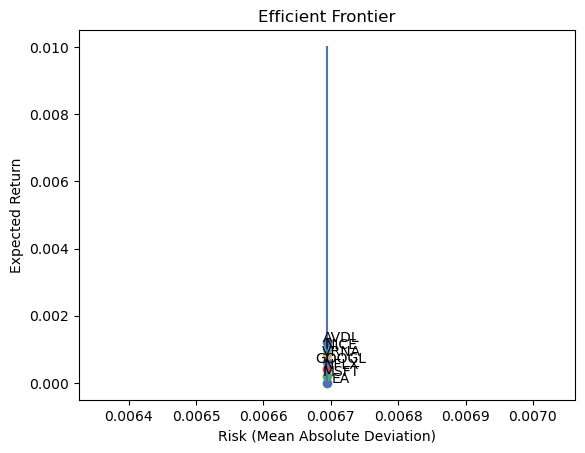

In [13]:
plt.figure()
plt.plot(risk_array, m0_array)

for i, stock in enumerate(assets):
    plt.annotate(
        stock,
        (risk_array[i], m0_array[i]),
        textcoords="offset points",
        xytext=(10, 0),
        ha="center",
    )

for i, stock in enumerate(assets):
    plt.scatter(risk_array[i], m0_array[i], label=stock)
plt.xlabel("Risk (Mean Absolute Deviation)")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier")

### efficient frontier for 1xx Model

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/26b05db399f64e1baa3d01a8b3e5eff4-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/26b05db399f64e1baa3d01a8b3e5eff4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 507 COLUMNS
At line 4772 RHS
At line 5275 BOUNDS
At line 5276 ENDATA
Problem MODEL has 502 rows, 257 columns and 4014 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 475 (-27) rows, 257 (0) columns and 3798 (-216) elements
Perturbing problem by 0.001% of 0.034065019 - largest nonzero change 4.9911956e-05 ( 7.8116392%) - largest zero change 4.2402071e-05
0  Obj -0 Primal inf 0.26956976 (1)
35  Obj -0.0010191582 Primal inf 348.77571 (223)
82  Obj -0.003250105 Primal inf 197.06329 (225)
132  Obj -0.0051266984 Primal inf 68.268781 (180)
177  Obj -0.006284498

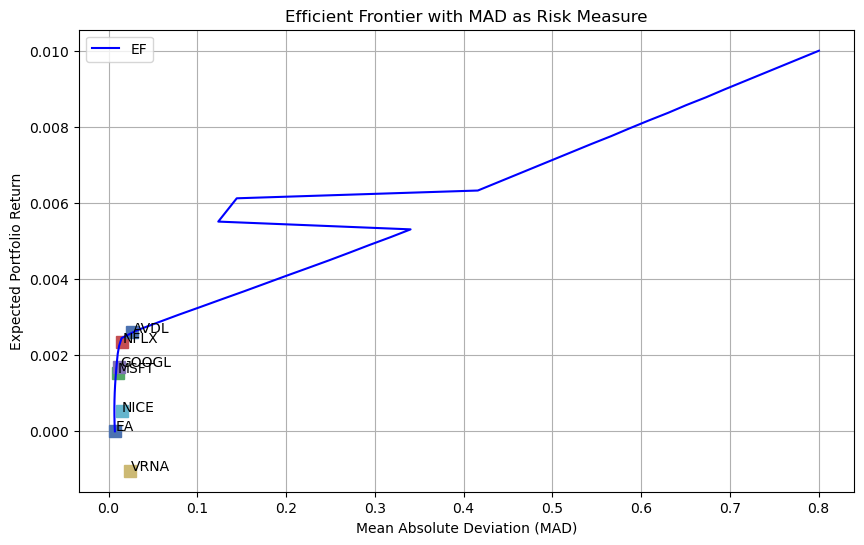

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import stats
from pulp import *

# Define the data
assets = ["EA", "MSFT", "NFLX", "GOOGL", "VRNA", "NICE", "AVDL"]

# Fetch historical data for each asset and calculate daily returns
R = []
for stock in assets:
    data = yf.Ticker(stock)
    df = data.history(period="1y")
    close = df["Close"].values
    returns = (close[1:] - close[:-1]) / close[:-1]
    R.append(returns)

R = np.array(R).T

# Calculate mean return and mean absolute deviation for each asset
mean_return = np.mean(R, axis=0)
mean_absolute_deviation = np.mean(np.abs(R - mean_return), axis=0)

# Define the efficient frontier function
def efficient_frontier(R, assets):
    # Define the data
    n = len(assets)  # Number of assets
    T = len(R[:, 0])  # Number of time periods

    m0_array = np.linspace(0.0, 0.01, 50)
    risk_array = np.zeros_like(m0_array)
    portfolio_returns = []
    portfolio_mads = []

    for i, m0 in enumerate(m0_array):
        # Create a LP problem
        prob = LpProblem("Financial_Portfolio_Optimization", LpMaximize)

        # Define decision variables
        x = [LpVariable(f"x{j}", lowBound=0) for j in range(n)]
        y = [LpVariable(f"y{t}", lowBound=0) for t in range(T)]

        # Define objective function
        prob += -(1 / T) * lpSum(y[t] for t in range(T)), "Objective"

        # Define constraints
        for t in range(T):
            prob += (
                lpSum(x[j] * (R[t][j] - mean_return[j]) for j in range(n)) <= y[t],
                f"Upper_constraint_{t}",
            )
            prob += (
                lpSum(x[j] * (R[t][j] - mean_return[j]) for j in range(n)) >= -y[t],
                f"Lower_constraint_{t}",
            )

        prob += lpSum(mean_return[j] * x[j] for j in range(n)) == m0

        prob += lpSum(x) == 1, "Sum_of_weights"

        # Solve the problem
        prob.solve()
        
        # Calculate portfolio return and MAD
        portfolio_return = value(lpSum(mean_return[j] * x[j] for j in range(n)))
        portfolio_mad = value((1 / T) * lpSum(y[t] for t in range(T)))

        # Store portfolio return and MAD
        portfolio_returns.append(portfolio_return)
        portfolio_mads.append(portfolio_mad)

        # Store risk
        risk_array[i] = portfolio_mad
    
    return risk_array, portfolio_returns, portfolio_mads

# Calculate efficient frontier points
risk_array, portfolio_returns, portfolio_mads = efficient_frontier(R, assets)

# Fit a linear regression line to the efficient frontier points
slope, intercept, _, _, _ = stats.linregress(risk_array, portfolio_returns)
efficient_line = slope * risk_array + intercept

# Plot both plots on the same graph
fig, ax = plt.subplots(figsize=(10, 6))

# Plot daily return versus mean absolute deviation
for i, asset in enumerate(assets):
    ax.plot(mean_absolute_deviation[i], mean_return[i], "s", ms=8)
    ax.text(mean_absolute_deviation[i] * 1.03, mean_return[i], asset)

#ax.set_xlim(0, 1.1 * np.max(mean_absolute_deviation))
#ax.axhline(0, color="r", linestyle="--")
ax.set_title("Daily return versus Mean Absolute Deviation")
ax.set_xlabel("Mean Absolute Deviation in Daily Returns")
ax.set_ylabel("Mean Daily Return")
ax.grid(True)

# Plot efficient frontier
#ax.plot(risk_array, efficient_line, label='Efficient Frontier Line', color='red')
ax.plot(portfolio_mads, portfolio_returns, color='blue', label='EF')
ax.set_xlabel('Mean Absolute Deviation (MAD)')
ax.set_ylabel('Expected Portfolio Return')
ax.legend()
plt.title('Efficient Frontier with MAD as Risk Measure')

plt.show()

# Now we consider risk as total variance of the portfolio, all these models are model 2x


Text(0.5, 1.0, 'Efficient Frontier')

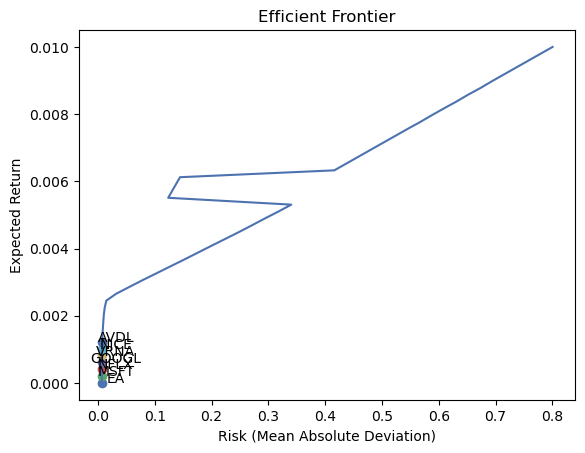

In [15]:
plt.figure()
plt.plot(risk_array, m0_array)

for i, stock in enumerate(assets):
    plt.annotate(
        stock,
        (risk_array[i], m0_array[i]),
        textcoords="offset points",
        xytext=(10, 0),
        ha="center",
    )

for i, stock in enumerate(assets):
    plt.scatter(risk_array[i], m0_array[i], label=stock)
plt.xlabel("Risk (Mean Absolute Deviation)")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier")

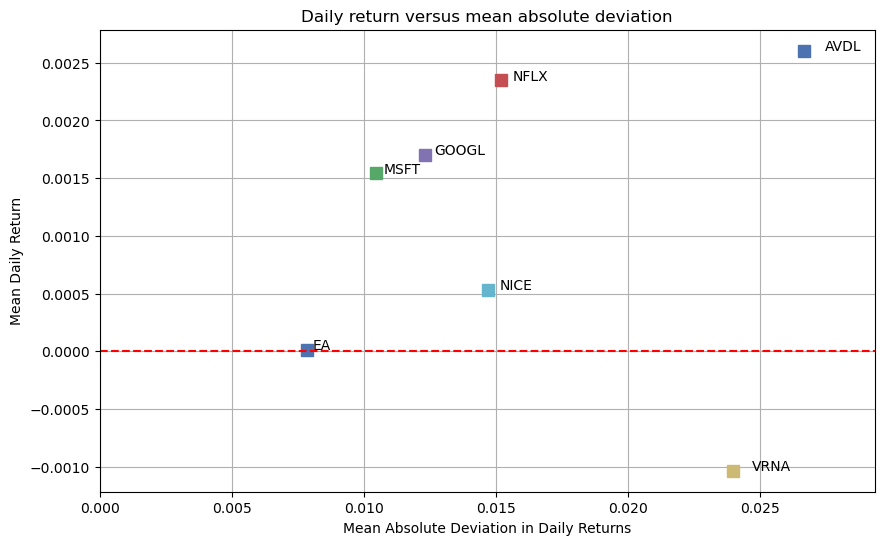

In [16]:
mean_return = np.mean(R, axis=0)
mean_absolute_deviation = np.mean(np.abs(R - mean_return), axis=0)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i, asset in enumerate(assets):
    ax.plot(mean_absolute_deviation[i], mean_return[i], "s", ms=8)
    ax.text(mean_absolute_deviation[i] * 1.03, mean_return[i], asset)

ax.set_xlim(0, 1.1 * np.max(mean_absolute_deviation))
ax.axhline(0, color="r", linestyle="--")
ax.set_title("Daily return versus mean absolute deviation")
ax.set_xlabel("Mean Absolute Deviation in Daily Returns")
ax.set_ylabel("Mean Daily Return")
ax.grid(True)

plt.show()


In [17]:
from pulp import *

# Define the data
n = len(assets)  # Number of assets
T = len(R[:, 0])  # Number of time periods
mu = 1
print(n, T, mu)

m0_array = np.linspace(0.0, 0.01, 50)
risk_array = 0.0 * m0_array
i = 0
for i in range(len(m0_array)):
    n = len(assets)  # Number of assets
    T = len(R[:, 0])  # Number of time periods
    mu = 1
    r0 = m0_array[i]

    # Create a LP problem
    prob = LpProblem("Financial_Portfolio_Optimization", LpMaximize)

    # Define decision variables
    x = [LpVariable(f"x{j}", lowBound=0) for j in range(n)]
    y = [LpVariable(f"y{t}", lowBound=0) for t in range(T)]

    # Define objective function
    prob += (
        lpSum(r[j] * x[j] for j in range(n)) * mu
        - (1 / T) * lpSum(y[t] for t in range(T)),
        "Objective",
    )

    # Define constraints
    for t in range(T):
        prob += (
            lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) <= y[t],
            f"Upper_constraint_{t}",
        )
        prob += (
            lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) >= -y[t],
            f"Lower_constraint_{t}",
        )

    prob += lpSum(x) == 1, "Sum_of_weights"

    # Solve the problem
    prob.solve()
    risk_array[i] = value((1 / T) * lpSum(y[t] for t in range(T)))

# Print the results
print("Status:", LpStatus[prob.status])
print("Optimal Portfolio Weights:")
for j in range(n):
    print(f"x{j}: {value(x[j])}")
print("expected return (MAD):", value(lpSum(r[j] * x[j] for j in range(n))))
print("Mean Absolute Deviation (MAD):", value((1 / T) * lpSum(y[t] for t in range(T))))

7 250 1
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/59cc5bd1e7ce49a491921b189fbc31ad-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/59cc5bd1e7ce49a491921b189fbc31ad-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 506 COLUMNS
At line 4771 RHS
At line 5273 BOUNDS
At line 5274 ENDATA
Problem MODEL has 501 rows, 257 columns and 4007 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 474 (-27) rows, 257 (0) columns and 3791 (-216) elements
Perturbing problem by 0.001% of 0.032939207 - largest nonzero change 8.1689831e-05 ( 34.718379%) - largest zero change 0
0  Obj -0 Primal inf 0.26956799 (1) Dual inf 0.034542789 (6)
57  Obj -0.00090784301 Primal inf 65.958379 (218)
107  Obj -0.0028031226 Primal inf 598.56309 (221)
159  Obj -0.0044272137 Primal inf 247.57677 (23

Text(0.5, 1.0, 'Efficient Frontier')

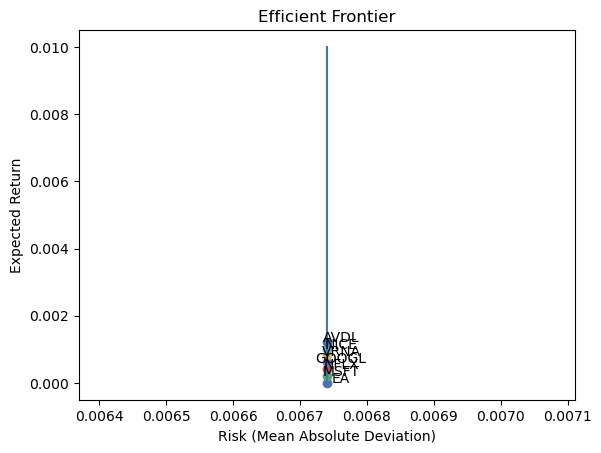

In [18]:
plt.figure()
plt.plot(risk_array, m0_array)

for i, stock in enumerate(assets):
    plt.annotate(
        stock,
        (risk_array[i], m0_array[i]),
        textcoords="offset points",
        xytext=(10, 0),
        ha="center",
    )

for i, stock in enumerate(assets):
    plt.scatter(risk_array[i], m0_array[i], label=stock)
plt.xlabel("Risk (Mean Absolute Deviation)")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier")

# model 2A
when we minimize variance under a specified expected return $r_0$
$$
\begin{gathered}
\operatorname{maximize} -\frac{1}{T} \sum_{t=1}^T\left(\sum_j x_j\left(R_j(t)-r_j\right)\right)^2 \\
\text { subject to } \sum_j x_j=1 \\
  \sum_j x_j r_j = r_0 \\
x_j \geq 0 \quad j=1,2, \ldots, n, \\
r_j=\frac{1}{T} \sum_{t=1}^T R_j(t)
\end{gathered}
$$

In [45]:
# centered return
R_c = 0.0 * R
for j in range(len(R[0, :])):
    R_c[:, j] = R[:, j] - r[j]

# print(np.outer(R_c[0,:],R_c[0,:]))
R_c.T @ R_c

# compute the convariance matrix manually
sig = 0.0 * S
for i in range(len(R[:, 0])):
    sig = sig + np.outer(R_c[i, :], R_c[i, :])
sig = sig / T


r0 = 0.2
n = len(R[0, :])
e = np.ones((n, 1))
rq = r.reshape(n, 1)

X = cp.Variable((n, 1))
Objective = cp.Minimize(cp.quad_form(X, sig))
constraints = [e.T @ X == 1, X >= 0, rq.T @ X >= r0]
problem = cp.Problem(Objective, constraints)

result = problem.solve()

print("expected portfolio", X.value.T)
print("expected return :", (rq.T @ X.value)[0])
print("Mean variance:", (X.value.T @ sig @ X.value)[0])
X

expected portfolio [[0.37040284 0.13595682 0.11393745 0.16224076 0.0842539  0.00235545
  0.13085278]]
expected return : [0.2]
Mean variance: [0.03969299]


Variable((7, 1), var3220)

### Model 2B

In [46]:
# centered return
R_c = 0. * R
for j in range(len(R[0,:])):
  R_c[:,j] = R[:,j] - r[j]

#print(np.outer(R_c[0,:],R_c[0,:]))
R_c.T @ R_c

# compute the convariance matrix manually
sig = 0. * S
for i in range(len(R[:,0])):
  sig = sig + np.outer(R_c[i,:],R_c[i,:])
sig = sig / T


v0 = 0.05
n = len(R[0,:])
e = np.ones((n,1))
rq = r.reshape(n,1)

X = cp.Variable((n,1))
Objective = cp.Maximize(rq.T@X)
constraints = [e.T@X == 1, X >= 0, cp.quad_form(X,sig) <= v0]
problem = cp.Problem(Objective,constraints)

result = problem.solve()

print("expected portfolio", X.value.T)
print("expected return :", (rq.T @ X.value)[0] )
print("Mean variance:", (X.value.T @ sig @ X.value)[0] )
print("Mean std:", (X.value.T @ sig @ X.value)[0]**0.5 )


expected portfolio [[3.29989287e-01 1.35798241e-01 1.32755237e-01 1.75872448e-01
  7.96961447e-02 2.35321121e-04 1.45653322e-01]]
expected return : [0.22449716]
Mean variance: [0.05]
Mean std: [0.2236068]


/opt/conda/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


### Model 2C

In [47]:
# centered return
R_c = 0. * R
for j in range(len(R[0,:])):
  R_c[:,j] = R[:,j] - r[j]

#print(np.outer(R_c[0,:],R_c[0,:]))
R_c.T @ R_c

# compute the convariance matrix manually
sig = 0. * S
for i in range(len(R[:,0])):
  sig = sig + np.outer(R_c[i,:],R_c[i,:])
sig = sig / T

mu = 0.5
n = len(R[0,:])
e = np.ones((n,1))
rq = r.reshape(n,1)

X = cp.Variable((n,1))
Objective = cp.Maximize(mu * rq.T@X - cp.quad_form(X,sig))
constraints = [e.T@X == 1, X >= 0]
problem = cp.Problem(Objective,constraints)

result = problem.solve()

print("expected portfolio", X.value.T)
print("expected return :", (rq.T @ X.value)[0] )
print("Mean variance:", (X.value.T @ sig @ X.value)[0] )
print("Mean std:", (X.value.T @ sig @ X.value)[0]**0.5 )

expected portfolio [[0.2748822  0.13952901 0.15754152 0.18134915 0.07577804 0.00828505
  0.16263504]]
expected return : [0.25219124]
Mean variance: [0.06308634]
Mean std: [0.25116994]


Text(0.5, 1.0, 'Efficient Frontier')

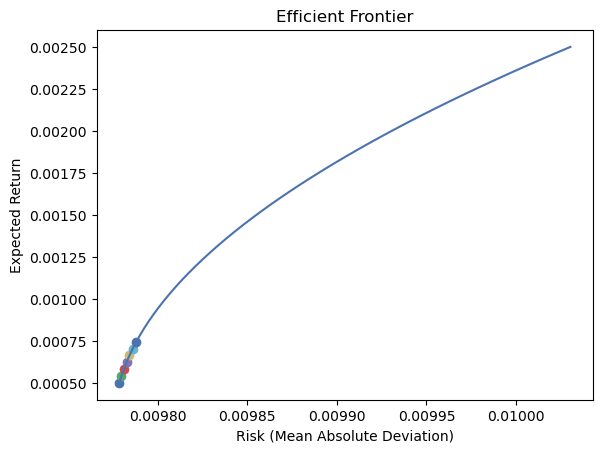

In [48]:
### Efficient Frontier
R_c = 0. * R
for j in range(len(R[0,:])):
  R_c[:,j] = R[:,j] - r[j]

#print(np.outer(R_c[0,:],R_c[0,:]))
R_c.T @ R_c

# compute the convariance matrix manually
sig = 0. * S
for i in range(len(R[:,0])):
  sig = sig + np.outer(R_c[i,:],R_c[i,:])
sig = sig / T

n = len(assets)  # Number of assets
T = len(R[:,0])  # Number of time periods
e = np.ones((n,1))
rq = r.reshape(n,1)

m0_array = np.linspace(0.0005,0.0025,50)
risk_array = 0. * m0_array
i = 0
for i in range(len(m0_array)):

  r0 = m0_array[i]

  X = cp.Variable((n,1))
  Objective = cp.Minimize(cp.quad_form(X,sig))
  constraints = [e.T@X == 1, X >= 0, rq.T@X == r0]
  problem = cp.Problem(Objective,constraints)

  result = problem.solve()

  risk_array[i] = (X.value.T @ sig @ X.value)[0,0]**0.5

#print("Status:", LpStatus[prob.status])
#print("Optimal Portfolio Weights:")
#for j in range(n):
    #print(f"x{j}: {value(x[j])}")
#print("expected return (MAD):", value(lpSum(r[j] * x[j] for j in range(n))))
#print("Mean Absolute Deviation (MAD):", value( (1/T) * lpSum(y[t] for t in range(T))))

plt.figure()
plt.plot(risk_array,m0_array)

for i, stock in enumerate(assets):
    plt.scatter(risk_array[i], m0_array[i], label=stock)
plt.xlabel("Risk (Mean Absolute Deviation)")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier")

## Optimization Problem

Choose a risk tolerance $q > 0$:

\begin{align*}
\text{minimize:} \ \ & \mathbf{x}^T \Sigma \mathbf{x} - q \mathbf{r}^T \mathbf{x} \\
\text{subject to:} \ \ & \mathbf{e}^T \mathbf{x} = 1 \\
& \mathbf{x} \geq 0 \\
\end{align*}

In [23]:
n = len(assets)
q = 0.1
e = np.ones(n)
X = cp.Variable(n)

obj = cp.Minimize(cp.quad_form(X, S) - q * r @ X)
constraints = [e @ X == 1, X >= 0]
problem = cp.Problem(obj, constraints)


result = problem.solve()
X.value

array([ 1.26366073e-01,  3.29517234e-01,  1.68917129e-01,  2.45165461e-01,
       -2.39262685e-23,  5.62573871e-23,  1.30034104e-01])

In [45]:
r

array([ 7.29372911e-05,  1.62370556e-03,  2.58240090e-03,  1.67817159e-03,
       -9.98607501e-04,  2.65355580e-04, -1.45890734e-03])

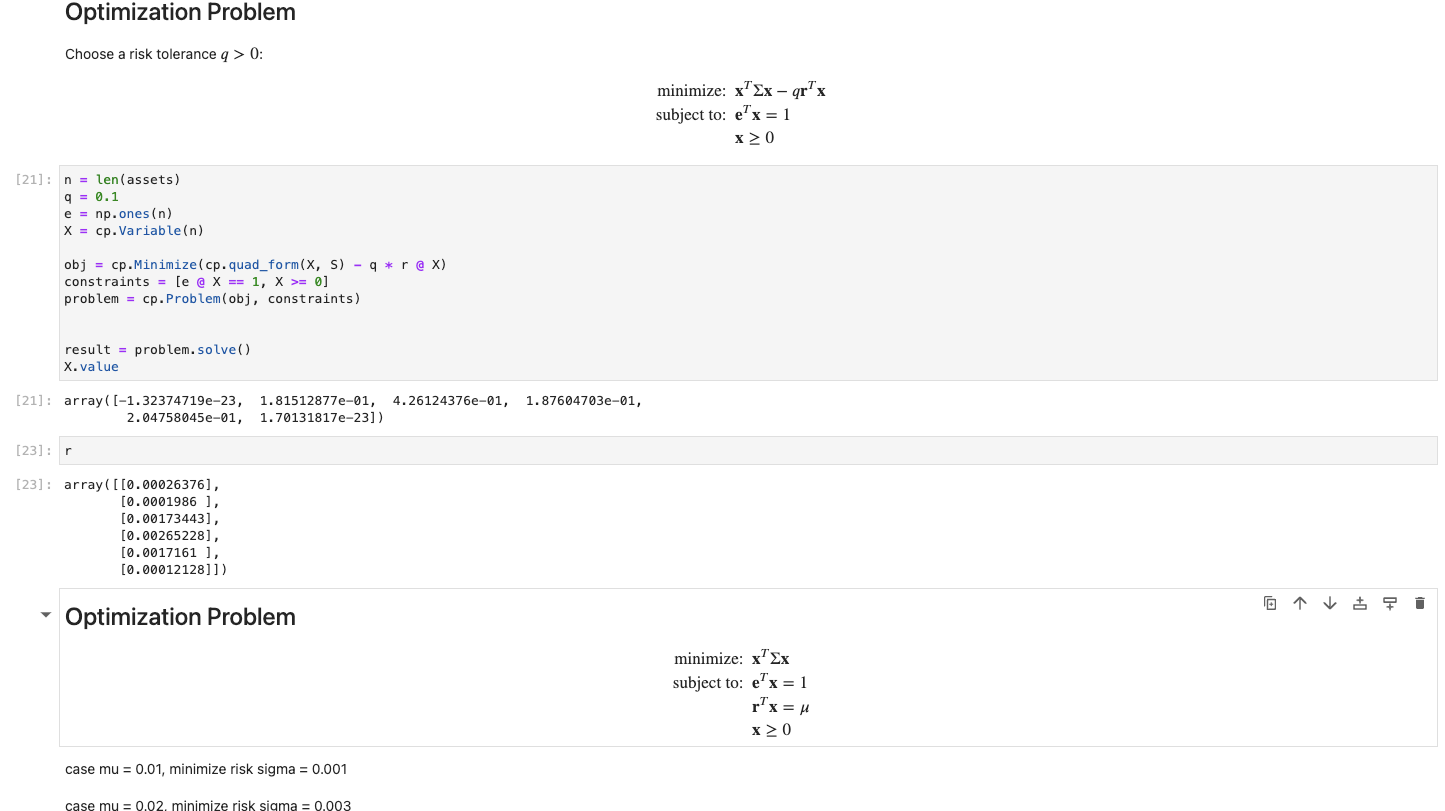## Optimization Problem

\begin{align*}
\text{minimize:} \ \ & \mathbf{x}^T \Sigma \mathbf{x} \\
\text{subject to:} \ \ & \mathbf{e}^T \mathbf{x} = 1 \\
& \mathbf{r}^T \mathbf{x} = \mu \\
& \mathbf{x} \geq 0 \\
\end{align*}

case mu = 0.01,   minimize risk sigma = 0.001

case mu = 0.02,  minimize risk sigma = 0.003

case mu = 0.05,  minimize risk  sigma = 0.010



In [46]:
n = len(assets)
e = np.ones((n, 1))
r = r.reshape(n, 1)
mu = 0.001

M = np.block([[2 * S, -r, -e], [r.T, 0, 0], [e.T, 0, 0]])
b = np.block([[np.zeros((n, 1))], [mu], [1]])

x = la.solve(M, b)
print(x)

[[ 4.98876837e-01]
 [ 3.01452391e-01]
 [ 7.97644938e-02]
 [ 1.47914940e-01]
 [ 5.12832624e-03]
 [-1.35071087e-02]
 [-1.96298783e-02]
 [ 2.27433122e-02]
 [ 1.57408519e-04]]


In [24]:
import pandas as pd
import yfinance as yf

T = 1  # Number of days in time period
assets = ["EA", "MSFT", "NFLX", "GOOGL", "VRNA", "NICE", "AVDL"]

# Initialize a dictionary to store stock prices
prices_dict = {}

# Loop through each stock and retrieve prices
for stock in assets:
    data = yf.Ticker(stock)
    df = data.history(period="1y")
    prices_dict[stock] = df["Close"]

# Create a DataFrame from the prices dictionary
df_prices = pd.DataFrame(prices_dict)

# Display the DataFrame
print(df_prices.head())

                                   EA        MSFT        NFLX       GOOGL  \
Date                                                                        
2023-04-24 00:00:00-04:00  128.731522  279.476227  329.019989  105.970001   
2023-04-25 00:00:00-04:00  128.751419  273.177917  322.549988  103.849998   
2023-04-26 00:00:00-04:00  124.396736  292.965546  321.149994  103.709999   
2023-04-27 00:00:00-04:00  125.778709  302.348541  325.850006  107.589996   
2023-04-28 00:00:00-04:00  126.544250  304.758789  329.929993  107.339996   

                                VRNA        NICE   AVDL  
Date                                                     
2023-04-24 00:00:00-04:00  23.000000  207.000000  10.66  
2023-04-25 00:00:00-04:00  22.594999  198.990005  10.19  
2023-04-26 00:00:00-04:00  22.340000  199.850006  10.04  
2023-04-27 00:00:00-04:00  21.360001  202.929993  10.09  
2023-04-28 00:00:00-04:00  20.950001  204.009995  10.48  


In [52]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage

mu = mean_historical_return(df_prices)
S = CovarianceShrinkage(df_prices).ledoit_wolf()

In [53]:
from pypfopt.efficient_frontier import EfficientFrontier

ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()

In [54]:
cleaned_weights = ef.clean_weights()
ef.save_weights_to_file("weights.txt")  # saves to file
print(cleaned_weights)

OrderedDict([('EA', 0.0), ('MSFT', 0.29907), ('NFLX', 0.2757), ('GOOGL', 0.2753), ('VRNA', 0.0), ('NICE', 0.0), ('AVDL', 0.14993)])


In [55]:
ret_optimal, vol_optimal, sharpe_ration = ef.portfolio_performance(verbose=True)

Expected annual return: 54.9%
Annual volatility: 20.1%
Sharpe Ratio: 2.62


In [56]:
from pypfopt import EfficientFrontier
ef_curve = EfficientFrontier(mu, S, weight_bounds = (0,1))
ef_curve

/opt/conda/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


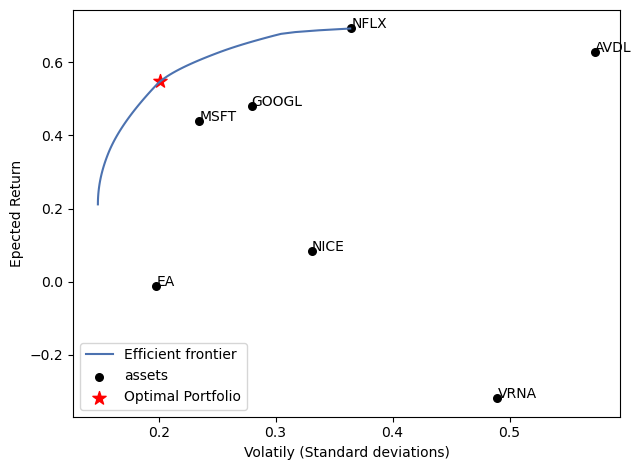

In [57]:
from pypfopt import plotting
fig,ax = plt.subplots()
plotting.plot_efficient_frontier(ef_curve, ax=ax, show_assets = True)

ax.scatter(vol_optimal, ret_optimal, marker = "*", s=100, c="r", label = "Optimal Portfolio")

for i, txt in enumerate(ef.tickers):
    ax.annotate(txt, ((np.diag(ef.cov_matrix) ** (1/2))[i], ef. expected_returns[i]))
    
    
ax.set_xlabel("Volatily (Standard deviations)")
ax.set_ylabel("Epected Return")
ax.legend()
plt.show()